In [3]:
from src.mitnanex import run
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity

In [4]:

clusters_list = run("test/a_gifuensis/mitnanex_results/a_gifuensis_all_containments.paf", 0.6)

# I need to plot the coverage of clusters
coverages_df = pd.DataFrame(
    {
        "coverage": [i.coverage for i in clusters_list.clusters],
        "repr_read_len": [i.longest_read_length for i in clusters_list.clusters],
        "id_longest_read": [i.longest_read_id for i in clusters_list.clusters],
        "id_cluster":[i.id_cluster for i in clusters_list.clusters],
    }
)

In [5]:
# Test on the first 30 clusters
import math
clusters = coverages_df.sort_values(by='coverage', ascending=False)
clusters.sort_values(by='id_longest_read',inplace=True)
clusters.head()

,coverage,repr_read_len,id_longest_read,id_cluster
74,2,15715,SRR11577123.1037,75
3,3,28927,SRR11577123.1405,4
99,2,12377,SRR11577123.2629,100
80,3,15279,SRR11577123.2652,81
103,2,10037,SRR11577123.333,104


# Coverage

The first step is to filter the reads by coverage. For that I will explore the use of Kernel Density since this is clusters_list one dimensional clustering.

In [6]:
clusters['transform'] = [math.log2(i)for i in clusters['coverage']]
clusters.sort_values('coverage',ascending=False, inplace=True)
clusters

,coverage,repr_read_len,id_longest_read,id_cluster,transform
4,28,28898,SRR11577127.5648,5,4.807355
10,11,28170,SRR11577128.1403,11,3.459432
25,5,25060,SRR11577129.1994,26,2.321928
0,4,29324,SRR11577125.3037,1,2.000000
19,3,25759,SRR11577125.3483,20,1.584963
...,...,...,...,...,...
42,2,21808,SRR11577125.7606,43,1.000000
35,2,22235,SRR11577125.7242,36,1.000000
101,2,10564,SRR11577125.7227,102,1.000000
111,2,6856,SRR11577125.6607,112,1.000000


<Axes: >

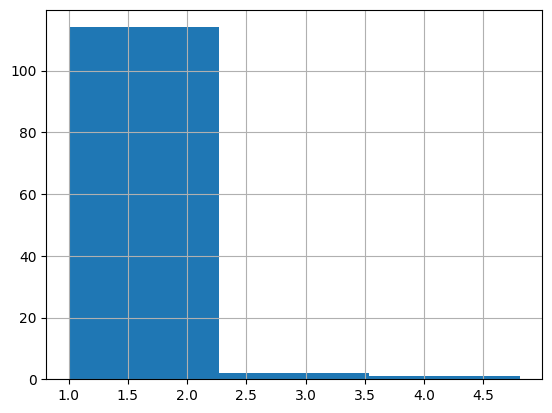

In [7]:
clusters['transform'].hist(bins=3)

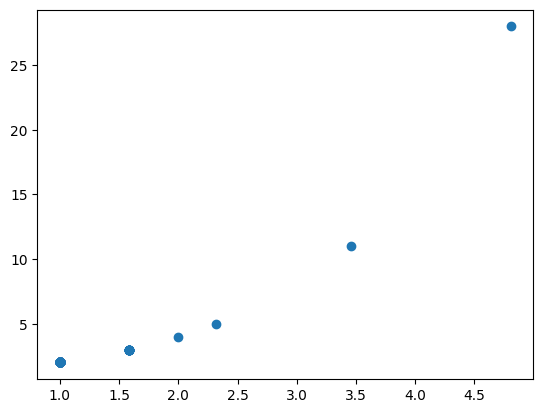

In [8]:
plt.scatter(x=clusters['transform'], y=clusters['coverage'])

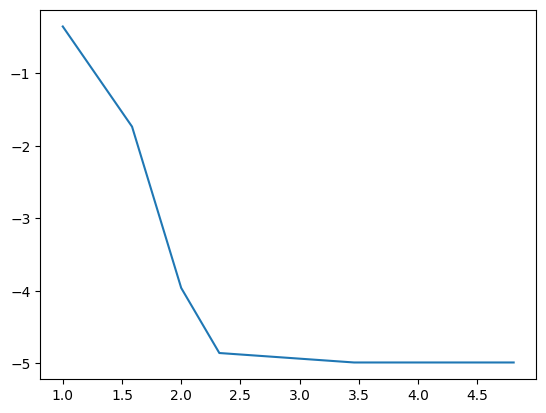

In [9]:
kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(clusters['coverage'].array.reshape(-1,1))
cov_fdp = kde.score_samples(clusters['coverage'].array.reshape(-1,1))
plt.plot(clusters['transform'], cov_fdp)

In [10]:
from scipy.signal import argrelextrema
import numpy as np
local_min = argrelextrema(cov_fdp, np.less)[0]
if len(local_min) < 1:
    min_coverage = 2
else:
    min_coverage = clusters.iloc[max(local_min),:]['coverage']
print("Covertura minima admitida: ", min_coverage)

Covertura minima admitida:  2


# Oligo composition

Once I've detected the clusters with higher coverage, which I expect includes mitochondria and contamination, whether nuclear or external, I have to purify these groups. To do this I will use the oligo composition as it is used during metagenomics binning.

I will create clusters_list script to get the kmers. The kmer size will be 3 to solve two things: 1. Intrinsec error from Nanopore, 2 smaller set as possible (4**3 possible kmers). 

Finally, I will reduce dimensionality using PCA

In [11]:
from src.utils import write_fasta
#from src.kmer_cnt import get_kmer_profiles
import utils_rs

In [12]:
reads_file = 'test/a_gifuensis//mitnanex_results/a_gifuensis_all_sample.sorted.fastq'
repr_reads = [i for i in clusters['id_longest_read']]

In [13]:
# PYTHON VERSION
# kmer_profiles_df = get_kmer_profiles (repr_reads, reads_file, 3)
# kmer_profiles_df.head()

In [14]:
# RUST VERSION
hist = utils_rs.get_kmer_profiles(repr_reads, reads_file, 3)
hist_df = pd.DataFrame(hist[0])
hist_df['ids'] = hist[1]
hist_df.head()
hist_df.iloc[:, :-1]

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,0.117174,0.094325,0.035807,0.033522,0.069499,0.033011,0.039967,0.042047,0.028304,0.014152,...,0.006172,0.006002,0.011049,0.007332,0.039422,0.013709,0.029362,0.022439,0.008184,0.014596
1,0.122307,0.096176,0.031021,0.031774,0.085095,0.027225,0.030406,0.038477,0.028867,0.014912,...,0.008995,0.007901,0.015665,0.007011,0.038204,0.015665,0.028935,0.016075,0.012894,0.014296
2,0.149853,0.113950,0.035286,0.028565,0.084596,0.030896,0.035423,0.040738,0.023867,0.012962,...,0.004526,0.003120,0.008093,0.002469,0.036109,0.011933,0.026164,0.014711,0.004835,0.011899
3,0.142635,0.117883,0.032772,0.026550,0.085768,0.031735,0.035814,0.040101,0.023438,0.015280,...,0.003630,0.003422,0.008919,0.004010,0.032426,0.010786,0.026722,0.017458,0.005946,0.011201
4,0.112811,0.086857,0.029967,0.026369,0.128902,0.022839,0.027511,0.027130,0.026161,0.019171,...,0.015018,0.014880,0.019205,0.013530,0.028653,0.015122,0.029725,0.016783,0.014845,0.018825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,0.120858,0.088016,0.028025,0.034010,0.114436,0.024814,0.041892,0.046563,0.029631,0.011969,...,0.004671,0.003649,0.010509,0.005693,0.031674,0.013575,0.035469,0.023500,0.009488,0.009926
113,0.141007,0.127112,0.027159,0.025264,0.115269,0.026212,0.034581,0.037581,0.027949,0.011369,...,0.003474,0.002842,0.008369,0.002369,0.037581,0.008843,0.036318,0.014843,0.004105,0.010895
114,0.138222,0.116590,0.032766,0.025767,0.094799,0.040560,0.042946,0.044218,0.025449,0.011293,...,0.003181,0.002227,0.009225,0.003181,0.029903,0.012088,0.025131,0.013043,0.005408,0.009384
115,0.110285,0.089512,0.031414,0.031751,0.065192,0.062489,0.051005,0.036480,0.022969,0.021787,...,0.002196,0.002533,0.011147,0.002702,0.035974,0.013342,0.031076,0.014525,0.004053,0.012160


In [15]:
## Get the real mt sequences
with open('test/a_gifuensis/chrMT_reads_ids.txt','r') as handle_ids_mt:
    ids_mt = handle_ids_mt.read().splitlines()
    ids_mt = [i[:].strip() for i in ids_mt]

# Dimensionality reduction with PCA and clustering with k-means 

In [16]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN

In [17]:
pca = PCA(n_components=2)
pca.fit(hist_df.iloc[:,:-2])

PCA(n_components=2)

In [18]:
## Components and variance explained 
pca.explained_variance_
#pca.components_

array([0.00080865, 0.00017255])

In [19]:
kmer_reduction = pca.fit_transform(hist_df.iloc[:,:-2])
kmer_reduction = pd.DataFrame(kmer_reduction, columns=['comp1', 'comp2'])

## merging the dataframe with ids and other relevant information
kmer_reduction ['ids'] = hist_df['ids']
kmer_reduction = kmer_reduction.merge(clusters, how='left', left_on='ids', right_on='id_longest_read')
kmer_reduction.drop(columns='id_longest_read', inplace=True)

## Annotate which reads are mitochondrial
kmer_reduction['mt'] = [32 if i else 10 for i in kmer_reduction['ids'].isin(ids_mt)] #+ 1) ** 5
kmer_reduction = kmer_reduction[kmer_reduction['coverage'] >= min_coverage]
kmer_reduction['coverage_norm'] = kmer_reduction['coverage'] / kmer_reduction['repr_read_len']
kmer_reduction

,comp1,comp2,ids,coverage,repr_read_len,id_cluster,transform,mt,coverage_norm
0,-0.034663,0.004960,SRR11577125.3037,4,29324,1,2.000000,10,0.000136
1,-0.019187,-0.005788,SRR11577123.6716,2,29238,2,1.000000,10,0.000068
2,0.012472,0.005137,SRR11577127.7308,3,29162,3,1.584963,10,0.000103
3,0.011218,0.013079,SRR11577123.1405,3,28927,4,1.584963,10,0.000104
4,-0.003806,-0.015313,SRR11577127.5648,28,28898,5,4.807355,10,0.000969
...,...,...,...,...,...,...,...,...,...
112,-0.013204,-0.007835,SRR11577126.7646,2,6851,113,1.000000,10,0.000292
113,0.031664,0.011815,SRR11577129.274,2,6333,114,1.000000,10,0.000316
114,0.011748,0.018999,SRR11577128.1734,2,6287,115,1.000000,10,0.000318
115,-0.049328,0.017939,SRR11577128.1763,2,5921,116,1.000000,10,0.000338


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'comp2')

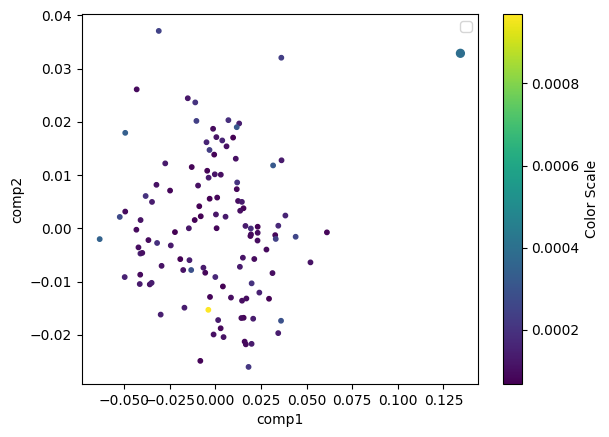

In [20]:
sc = plt.scatter(kmer_reduction['comp1'],kmer_reduction['comp2'], c=kmer_reduction['coverage_norm'], s=kmer_reduction['mt'])
# legend
# Add clusters_list colorbar
cbar = plt.colorbar(sc)
cbar.set_label('Color Scale')
plt.legend()
plt.xlabel('comp1')
plt.ylabel('comp2')

In [21]:
kmeans = KMeans(n_clusters=2, max_iter=100, init='k-means++', random_state=0, n_init=1,verbose=1)
mt_prediction = kmeans.fit_predict(kmer_reduction[['comp1','comp2']])#, sample_weight=kmer_reduction['coverage'])
kmer_reduction['cluster_prediction'] = mt_prediction

Initialization complete
Iteration 0, inertia 0.09238633814376616.
Iteration 1, inertia 0.06685930094776174.
Iteration 2, inertia 0.06180395268328003.
Iteration 3, inertia 0.05998202098711691.
Iteration 4, inertia 0.0593640729599212.
Iteration 5, inertia 0.05915863771453196.
Iteration 6, inertia 0.05884980527121674.
Iteration 7, inertia 0.058773070571496.
Iteration 8, inertia 0.05870337867108294.
Iteration 9, inertia 0.058635968217173415.
Iteration 10, inertia 0.05853925998297588.
Iteration 11, inertia 0.05846605657001506.
Iteration 12, inertia 0.058447883356280914.
Converged at iteration 12: strict convergence.


Text(0, 0.5, 'comp2')

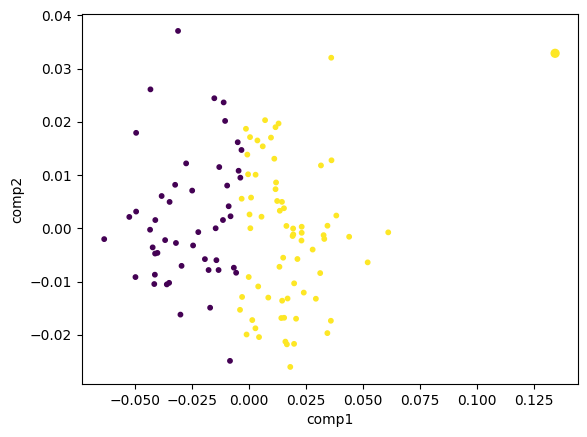

In [22]:
plt.scatter(x=kmer_reduction['comp1'], y=kmer_reduction['comp2'], c=mt_prediction, s=kmer_reduction['mt'])
plt.xlabel('comp1')
plt.ylabel('comp2')

In [23]:
# dbscan = DBSCAN(eps=3, min_samples=3)
# mt_prediction = dbscan.fit_predict(kmer_reduction[['comp1','comp2']])#, sample_weight=kmer_reduction['coverage'])
# kmer_reduction['cluster_prediction'] = mt_prediction
# kmer_reduction.head()

In [24]:
# plt.scatter(x=kmer_reduction['comp1'], y=kmer_reduction['comp2'], c=mt_prediction, s=kmer_reduction['mt'])
# plt.xlabel('comp1')
# plt.ylabel('comp2')

# Get the cluster of interest

This step is clusters_list pain in the ass, but since I am looking to keep the free-reference. 

In [30]:
selected_cluster_id = kmer_reduction.loc[:, kmer_reduction.columns != 'ids'].groupby(by='cluster_prediction')['coverage_norm'].sum().idxmax()
selected_cluster = kmer_reduction[kmer_reduction['cluster_prediction'] == selected_cluster_id]
selected_cluster.sort_values('coverage_norm', inplace=True, ascending=False)
selected_cluster.head()

/var/folders/20/bjqv2gj50z7dx4ksyh4y8b800000gn/T/ipykernel_58893/2504861273.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_cluster.sort_values('coverage_norm', inplace=True, ascending=False)


,comp1,comp2,ids,coverage,repr_read_len,id_cluster,transform,mt,coverage_norm,cluster_prediction
4,-0.003806,-0.015313,SRR11577127.5648,28,28898,5,4.807355,10,0.000969,1
10,0.134268,0.032883,SRR11577128.1403,11,28170,11,3.459432,32,0.000390,1
114,0.011748,0.018999,SRR11577128.1734,2,6287,115,1.000000,10,0.000318,1
113,0.031664,0.011815,SRR11577129.274,2,6333,114,1.000000,10,0.000316,1
111,0.036007,-0.017368,SRR11577125.6607,2,6856,112,1.000000,10,0.000292,1


In [26]:
sequences_ids = set()
for i in selected_cluster['id_cluster']:
    sequences_ids.update(clusters_list.get_cluster(i).id_sequences)
write_fasta(reads_file=reads_file, sequences_ids=sequences_ids, output='test/s_cervisae_CEN_PK113-7D/mt_reads_v1.fasta')

-> 180 reads retrieved
